<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/5%20Procesado%20del%20lenguaje%20natural/Sesion%203/NLP_08d_Clasificador_binario_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de texto con CNN
Implementemos un clasificador con Convolutional Neural Networks aplicado al análisis de sentimiento en Twitter usando la librería `Keras`.  
Aplicamos una primera capa de embeddings para convertir las palabras en vectores y luego entrenamos con una red CNN (seleccionando el max-pooling de cada filtro para obtener un vector por tweet).  
Para calcular los embeddings usamos:  
- Una capa de embeddings propia sobre los tweets
- Transfer Learning con los word embeddings de spaCy 
- Transfer Learning con los word embeddings de GloVe 

Implementado según el modelo planteado en [Convolutional Neural Networks for Sentence Classification](http://arxiv.org/abs/1408.5882)

In [1]:
#(ejecutar esto sólo si estás en Colab)
!python -m spacy download es_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [2]:
import pandas as pd
import numpy as np
import re, string, spacy
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Activation, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = None
np.random.seed(123)

In [3]:
# Leemos los datos
#LOCAL:
#df = pd.read_csv('tweets_all.csv', index_col=None)
#GITHUB:
df = pd.read_csv('https://raw.githubusercontent.com/vicentcamison/idal_ia3/main/5%20Procesado%20del%20lenguaje%20natural/Sesion%203/tweets_all.csv', index_col=None)

#seleccionamos columnas de interés
df = df[['content', 'polarity']]

#dejamos polaridades definidas
df = df[(df['polarity']=='P') | (df['polarity']=='N')]

df.head()

,content,polarity
1,"@myendlesshazza a. que puto mal escribo\n\nb. me sigo surrando help \n\n3. ha quedado raro el ""cómetelo"" ahí JAJAJAJA",N
2,@estherct209 jajajaja la tuya y la d mucha gente seguro!! Pero yo no puedo sin mi melena me muero,N
3,Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps,P
4,Vale he visto la tia bebiendose su regla y me hs dado muchs grima,N
5,@Yulian_Poe @guillermoterry1 Ah. mucho más por supuesto! solo que lo incluyo. Me habías entendido mal,P


In [4]:
df.polarity.value_counts()

N    637
P    474
Name: polarity, dtype: int64

## Limpieza de texto
Usamos Spacy para separar el texto en tokens y mantener sólo las palabras importantes, dejando su lemma

In [5]:
import re, string, spacy
nlp=spacy.load('es_core_news_md')

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text) #elimina menciones y URL
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens] #no quitamos stop-words
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text
    

## Preparamos el conjunto de datos
Convertimos el texto en *tokens* y asignamos una ID numérica a cada token.  
Convertimos a secuencias de longitud fija.  
La longitud de la secuencia viene dada por la longitud en tokens del tweet más largo. Sólo se conservan los tokens de las palabras en el vocabulario.

In [7]:
#limpiamos texto y quitamos tweets que se han quedado vacíos
df.content=df.content.apply(clean_text, lemas=True)
df = df[df['content']!='']

#el conjunto de salida es la polaridad, hay que convertir a numérico para Keras
#codificamos 'P' como 1 y 'N' se queda como 0
Y=(df.polarity=='P').values*1

#Separamos entrenamiento y test
tweets_train, tweets_test, Y_train, Y_test = train_test_split(df.content,Y, test_size = 0.3, random_state = 42)

In [8]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(tweets_train.values)
X_train = tokenizer.texts_to_sequences(tweets_train.values)
X_train = pad_sequences(X_train, padding='post')
word_index = tokenizer.word_index
print(f'Número de tokens distintos: {len(word_index)}')
MAX_SEQUENCE_LENGTH = X_train.shape[1]
max_features = len(word_index)+1
X_test = tokenizer.texts_to_sequences(tweets_test.values)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

Número de tokens distintos: 2606


In [34]:
#Este es el diccionario de tokens que se ha creado al aplicar el tokenizer
print(tokenizer.word_index)

{'que': 1, 'de': 2, 'ser': 3, 'lo': 4, 'el': 5, 'y': 6, 'no': 7, 'a': 8, 'me': 9, 'uno': 10, 'en': 11, 'haber': 12, 'tener': 13, 'pero': 14, 'estar': 15, 'mi': 16, 'por': 17, 'se': 18, 'yo': 19, 'los': 20, 'ya': 21, 'ir': 22, 'te': 23, 'con': 24, 'poder': 25, 'hacer': 26, 'parir': 27, 'todo': 28, 'bueno': 29, 'ver': 30, 'este': 31, 'si': 32, 'muy': 33, 'ese': 34, 'comer': 35, 'al': 36, 'porque': 37, 'del': 38, 'mucho': 39, 'decir': 40, 'más': 41, 'día': 42, 'o': 43, 'poner': 44, 'coser': 45, 'solo': 46, 'dar': 47, 'cuando': 48, 'su': 49, 'mejor': 50, 'pasar': 51, 'gracia': 52, 'tu': 53, 'querer': 54, 'tan': 55, 'asir': 56, 'gente': 57, 'salir': 58, 'le': 59, 'bien': 60, 'vez': 61, 'qué': 62, 'algo': 63, 'otro': 64, 'nadar': 65, 'mismo': 66, 'ahora': 67, 'mal': 68, 'feliz': 69, 'hoy': 70, 'malo': 71, 'q': 72, 'es': 73, 'saber': 74, 'poco': 75, 'seguir': 76, 'pues': 77, 'menos': 78, 'gran': 79, 'volver': 80, 'dejar': 81, 'dormir': 82, 'hora': 83, 'bonito': 84, 'tú': 85, 'genial': 86, 'vi

In [9]:
X_train.shape

(777, 30)

In [10]:
X_train[0]

array([ 15, 375,   6,   8,  61,   9,  26, 490,  37,  18,  22,   8, 804,
       491,   2,  64, 216,   6,   7,   9,  40,  65, 805,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [11]:
tweets_train.values[0]

'  estar enamorar y a vez me hacer dañar porque se ir a chupar culo de otro perro y no me decir nadar   crisis'

In [12]:
word_index['después']

290

In [13]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(777, 30) (777,)
(334, 30) (334,)


## Word embeddins propios
Entrenamos una capa de embedding para aprender los WE con los textos de nuestro problema.

In [14]:
#Creamos el modelo CNN en Keras
#Usamos como referencia el ejemplo de Keras: https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py
#pero quitamos la capa oculta intermedia para simplificar el modelo y dejarlo como en el artículo

#Parámetros de la red
embed_dim = 50
filters = 64
kernel_size = 3

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.2))

# añadimos una capa de convolución 1D que aprende
# filtros de grupos de palabras de tamaño kernel_size
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# calculamos el max pooling:
model.add(GlobalMaxPooling1D())

# conectamos a una capa de salida de una unidad con activación sigmoide
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compilamos el modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            130350    
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 64)            9664      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 140,079
Trainable params: 140,079
Non-trainable params: 0
__________________________________________________

### Pregunta:
¿de dónde vienen los tamaños de los parámetros de cada capa?

In [15]:
#solución
print(max_features * embed_dim)
print(filters*embed_dim*kernel_size+filters)
print(filters+1)

130350
9664
65


In [16]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/20
49/49 - 2s - loss: 0.6820 - accuracy: 0.5804 - val_loss: 0.6822 - val_accuracy: 0.5569
Epoch 2/20
49/49 - 0s - loss: 0.6600 - accuracy: 0.5804 - val_loss: 0.6682 - val_accuracy: 0.5569
Epoch 3/20
49/49 - 0s - loss: 0.6147 - accuracy: 0.6384 - val_loss: 0.6272 - val_accuracy: 0.6647
Epoch 4/20
49/49 - 0s - loss: 0.5182 - accuracy: 0.8443 - val_loss: 0.5747 - val_accuracy: 0.7275
Epoch 5/20
49/49 - 0s - loss: 0.3733 - accuracy: 0.8983 - val_loss: 0.5384 - val_accuracy: 0.7545
Epoch 6/20
49/49 - 0s - loss: 0.2267 - accuracy: 0.9588 - val_loss: 0.5465 - val_accuracy: 0.7695
Epoch 7/20
49/49 - 0s - loss: 0.1256 - accuracy: 0.9820 - val_loss: 0.5672 - val_accuracy: 0.7515
Epoch 8/20
49/49 - 0s - loss: 0.0642 - accuracy: 0.9949 - val_loss: 0.6238 - val_accuracy: 0.7365
Epoch 9/20
49/49 - 0s - loss: 0.0396 - accuracy: 0.9974 - val_loss: 0.6723 - val_accuracy: 0.7395
Epoch 10/20
49/49 - 0s - loss: 0.0244 - accuracy: 0.9974 - val_loss: 0.6796 - val_accuracy: 0.7455
Epoch 11/20
49/49 -

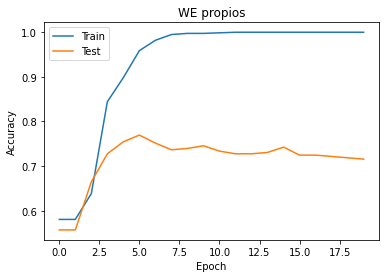

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('WE propios')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
#los word embeddings aprendidos son los pesos de la primera capa
embeddings=model.get_weights()[0]

In [19]:
embeddings.shape

(2607, 50)

In [20]:
embeddings[1]

array([ 0.06848046, -0.03185182,  0.0217838 , -0.03959312,  0.00657247,
       -0.037142  ,  0.01262981, -0.01940588, -0.08902517, -0.03203628,
        0.04225971,  0.03595794, -0.01213439, -0.06424483, -0.01469962,
       -0.03399598,  0.03240829,  0.0078414 , -0.05154438,  0.0204957 ,
        0.0585907 ,  0.02564078, -0.02995742, -0.03373651, -0.04984083,
        0.01461077,  0.06644509, -0.02141668,  0.10427225,  0.05907809,
        0.01692927,  0.02496457,  0.00951653, -0.0157396 , -0.02677639,
        0.02135545,  0.02956246, -0.01711577, -0.02729973,  0.05555876,
       -0.01156183,  0.02772356, -0.04483744, -0.02107281, -0.03914533,
       -0.01220341, -0.03153637, -0.00764413,  0.01661984,  0.01624751],
      dtype=float32)

In [21]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

21/21 - 0s - loss: 0.9175 - accuracy: 0.7156
score: 0.92
acc: 0.72


In [22]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

              precision    recall  f1-score   support

           N       0.72      0.81      0.76       186
           P       0.72      0.59      0.65       148

    accuracy                           0.72       334
   macro avg       0.72      0.70      0.71       334
weighted avg       0.72      0.72      0.71       334



### Ejercicio 1
Introduce una capa densa de 50 neuronas, con un Dropout con p=0.4 y una función de activación 'ReLU' entre la salida de la capa convolucional (después del MaxPooling) y la capa de salida. Compila y entrena con un tamaño de batch de 16 y 20 épocas.

In [23]:
# Solución
#Creamos el modelo CNN en Keras
#Usamos como referencia el ejemplo de Keras: https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py
#pero quitamos la capa oculta intermedia para simplificar el modelo y dejarlo como en el artículo

#Parámetros de la red
embed_dim = 50
filters = 64
kernel_size = 3

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.2))

# añadimos una capa de convolución 1D que aprende
# filtros de grupos de palabras de tamaño kernel_size
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# calculamos el max pooling:
model.add(GlobalMaxPooling1D())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))

# conectamos a una capa de salida de una unidad con activación sigmoide
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compilamos el modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 50)            130350    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            9664      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

Compara los resultados con los anteriores

In [24]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/20
49/49 - 1s - loss: 0.6854 - accuracy: 0.5431 - val_loss: 0.6841 - val_accuracy: 0.5569
Epoch 2/20
49/49 - 0s - loss: 0.6667 - accuracy: 0.5817 - val_loss: 0.6676 - val_accuracy: 0.5569
Epoch 3/20
49/49 - 0s - loss: 0.6227 - accuracy: 0.6178 - val_loss: 0.6292 - val_accuracy: 0.6647
Epoch 4/20
49/49 - 0s - loss: 0.5254 - accuracy: 0.8301 - val_loss: 0.5586 - val_accuracy: 0.7246
Epoch 5/20
49/49 - 0s - loss: 0.3300 - accuracy: 0.9138 - val_loss: 0.5155 - val_accuracy: 0.7575
Epoch 6/20
49/49 - 0s - loss: 0.1487 - accuracy: 0.9627 - val_loss: 0.5514 - val_accuracy: 0.7665
Epoch 7/20
49/49 - 0s - loss: 0.0625 - accuracy: 0.9897 - val_loss: 0.6523 - val_accuracy: 0.7485
Epoch 8/20
49/49 - 0s - loss: 0.0266 - accuracy: 0.9987 - val_loss: 0.6843 - val_accuracy: 0.7425
Epoch 9/20
49/49 - 0s - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.7541 - val_accuracy: 0.7275
Epoch 10/20
49/49 - 0s - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.7898 - val_accuracy: 0.7275
Epoch 11/20
49/49 -

In [25]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

21/21 - 0s - loss: 1.0321 - accuracy: 0.7365
score: 1.03
acc: 0.74


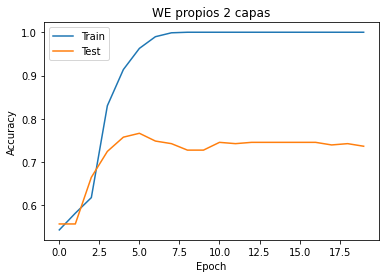

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('WE propios 2 capas')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

              precision    recall  f1-score   support

           N       0.76      0.77      0.76       186
           P       0.71      0.70      0.70       148

    accuracy                           0.74       334
   macro avg       0.73      0.73      0.73       334
weighted avg       0.74      0.74      0.74       334



## Word embeddings de spaCy
Aplicamos Transfer Learning usando los embeddings GloVe incluidos en el modelo de spaCy.

In [28]:
nlp=spacy.load('es_core_news_md')
#Rellenamos los vectores con el valor en spaCy para nuestro vocabulario
EMBEDDING_DIM = nlp.vocab.vectors_length
embedding_matrix = np.zeros((max_features, EMBEDDING_DIM))
for word, i in word_index.items():
    if(i>max_features):
        break
    embedding_vector = nlp.vocab[word].vector
    if embedding_vector is not None:
        # las palabras que no están en spaCy serán cero.
        embedding_matrix[i] = embedding_vector

In [29]:
embedding_matrix.shape

(2607, 50)

In [30]:
#Creamos el modelo CNN en Keras

#parámetros de la red
filters = 64
kernel_size = 3

embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 50)            130350    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 64)            9664      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 140,079
Trainable params: 140,079
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/20
49/49 - 1s - loss: 0.7146 - accuracy: 0.5534 - val_loss: 0.6753 - val_accuracy: 0.5898
Epoch 2/20
49/49 - 0s - loss: 0.6632 - accuracy: 0.5972 - val_loss: 0.6426 - val_accuracy: 0.6497
Epoch 3/20
49/49 - 0s - loss: 0.6126 - accuracy: 0.6615 - val_loss: 0.6207 - val_accuracy: 0.6796
Epoch 4/20
49/49 - 0s - loss: 0.5588 - accuracy: 0.7310 - val_loss: 0.5966 - val_accuracy: 0.7036
Epoch 5/20
49/49 - 0s - loss: 0.5157 - accuracy: 0.7619 - val_loss: 0.5770 - val_accuracy: 0.7126
Epoch 6/20
49/49 - 0s - loss: 0.4878 - accuracy: 0.7825 - val_loss: 0.5723 - val_accuracy: 0.7156
Epoch 7/20
49/49 - 0s - loss: 0.4572 - accuracy: 0.8211 - val_loss: 0.5614 - val_accuracy: 0.7575
Epoch 8/20
49/49 - 0s - loss: 0.3975 - accuracy: 0.8378 - val_loss: 0.6558 - val_accuracy: 0.6018
Epoch 9/20
49/49 - 0s - loss: 0.4022 - accuracy: 0.8327 - val_loss: 0.5510 - val_accuracy: 0.7335
Epoch 10/20
49/49 - 0s - loss: 0.3460 - accuracy: 0.8726 - val_loss: 0.5701 - val_accuracy: 0.7246
Epoch 11/20
49/49 -

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('TF con WE spaCy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [ ]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

### Word embeddings de FastText
Podemos usar cualquier conjunto de *word embeddings* con el formato `KeyedVectors` de Gensim para hacer Transfer Learning.  
WE descargados desde https://fasttext.cc/docs/en/crawl-vectors.html

In [ ]:
from gensim.models import KeyedVectors
modelWE = KeyedVectors.load_word2vec_format('/Users/jovifran/Downloads/fasttext-sbwc.100k.vec')

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
#https://github.com/mquezada/starsconf2018-word-embeddings
modelWE = KeyedVectors.load_word2vec_format('~/Downloads/fasttext-sbwc.100k.vec')

EMBEDDING_DIM = modelWE.vector_size

embedding_matrix = np.zeros((max_features, EMBEDDING_DIM))
vectores = 0
for word, i in word_index.items():
    if(i<max_features):
        try:
            embedding_vector = modelWE[word]
        except:
            embedding_vector = np.zeros(EMBEDDING_DIM)
            # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vectores += 1
        
print("Cargados {} vectores en la matriz".format(vectores))

In [ ]:
max_features

In [ ]:
embedding_matrix.shape

In [ ]:
#Creamos el modelo CNN en Keras

#parámetros de la red
filters = 64
kernel_size = 3

embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('TF con WE FastText')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [ ]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

### Inferencia en nuevos textos

Si queremos utilizar el clasificador con un texto nuevo hay que procesar el texto con la misma secuencia: limpieza, tokenizado y conversión en secuencia de la longitud adecuada:

In [ ]:
twt = 'estoy triste con el partido'
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences([clean_text(twt, lemas=True)]) #hay que pasar el texto a array
#padding the tweet to have exactly the same shape as `embedding_2` input

In [ ]:
twt = pad_sequences(twt, maxlen=X_train.shape[1], dtype='int32', padding='post', truncating='post', value=0)
sentiment = model.predict(twt,batch_size=1,verbose = 2)
if(np.round(sentiment) == 0):
    print("negativo")
elif (np.round(sentiment) == 1):
    print("positivo")

### Ejercicio 2
Repite el entrenamiento con la capa de embeddings de spaCy con `trainable = True` y compara los resultados.

In [ ]:
## Solución